In [17]:
import serial
from time import sleep
import numpy as np
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [18]:
def a2s(arr):
    """ Array of integer byte values --> binary string
    """
    return ''.join(chr(b) for b in arr)

In [19]:
def commarduino(azim,elev):
    # this azim must be already elevation offset-corrected
    try:
        ser = serial.Serial('/dev/ttyACM0', 9600) # Establish the connection on a specific port
    except:
        ser = serial.Serial('/dev/ttyACM1', 9600) # Establish the connection on a specific port
    azbin=bin(azim*10) # arduino serial receives a 16 bit int, so we have 1 decimal precision if multiplied by 10
    azpadn=16-len(azbin[2:])
    azbin='0b'+azpadn*'0'+azbin[2:]
    altbin=bin(elev*10) # arduino serial receives a 16 bit int, so we have 1 decimal precision if multiplied by 10
    altpadn=16-len(altbin[2:])
    altbin='0b'+altpadn*'0'+altbin[2:]
    # split each coordinate's 16 bit int into two 8 bit ints
    # is reconstituted in the arduino
    ser.write(a2s([int(azbin[2:-8],2),int(azbin[-8:],2),int(altbin[2:-8],2),int(altbin[-8:],2)]))
    ser.close()

In [20]:
# azimuth correction due to pitch offset
def az_corr(eloff,el):
    el=el*np.pi/180
    eloff=eloff*np.pi/180
    omega=np.arcsin(np.sin(el)/np.cos(eloff))
    return -np.arctan2(np.cos(omega),np.sin(omega)*np.sin(eloff))*180/np.pi

In [21]:
eloff=4 ## offset, should be measured via pitch

In [22]:
# this block sets the availability of az for each el
azlimlo=360 # this should me measured (max az range for the antenna mount)
azlimup=180 # this should me measured (min az range for the antenna mount)
el=np.linspace(0,90-eloff,90-eloff+1)*np.pi/180
omega=np.arcsin(np.sin(el)/np.cos(eloff*np.pi/180))
azcor=-np.arctan2(np.cos(omega),np.sin(omega)*np.sin(eloff*np.pi/180))*180/np.pi
lowerang=azlimlo-azcor-360
upperang=azlimup-azcor

In [25]:
obj = SkyCoord(266.41, -29.01, unit="deg")
ecci = EarthLocation(lat=4.71*u.deg, lon=-72.07*u.deg, height=2600*u.m)
utcoffset = 5*u.hour  # Bogota time

for i in range(15):
    print "****************************"
    print "New coordinates from script:"
    print "****************************"
    time = Time.now()
    objaltaz = obj.transform_to(AltAz(obstime=time,location=ecci))  
    azimuth=int(np.around(objaltaz.az.degree,0))
    elevation=int(np.around(objaltaz.alt.degree,0))
    filtel=((el*180/np.pi).astype(int)==elevation)
    print time - utcoffset," Azimuth = ",azimuth, "Elevation = ", elevation
    if (elevation > 0):
        if not(lowerang[filtel] < azimuth < upperang[filtel]):
            print "Desired Az must be between %i and %i" %(lowerang[filtel][0],upperang[filtel][0])
            print "Az is currently set to %i" % azimuth
            print "Stopping the telescope now. Waiting for new coordinates from the astropy block."
            azimuth = 500
            elevation = 200
            commarduino(azimuth,elevation)
            ## communicate this to the arduino
        else:
            print "Setting the telescope to Az = %i and El = %i" %(azimuth, elevation)
            print "Corrected azimuth = % i" % (np.around(azimuth-az_corr(eloff,elevation),0))
            commarduino(int(np.around(azimuth-az_corr(eloff,elevation),0)),elevation)
            ## communicate corrected azimuth to the arduino
        print  " "
    else:
        print "Desired El must be greater than zero"
        print "El is currently set to %i" % elevation
        print "Stopping the telescope now. Waiting for new coordinates from the astropy block."
        azimuth = 500
        elevation = 200
        commarduino(azimuth,elevation)
        ## communicate this to the arduino
    sleep(10) # this should be at least an order of magnitude higher than the arduino loop delay

****************************
New coordinates from script:
****************************
2016-11-10 17:00:16.194570  Azimuth =  227 Elevation =  38
Setting the telescope to Az = 227 and El = 38
Corrected azimuth =  314
 
****************************
New coordinates from script:
****************************
2016-11-10 17:00:26.229974  Azimuth =  227 Elevation =  38
Setting the telescope to Az = 227 and El = 38
Corrected azimuth =  314
 
****************************
New coordinates from script:
****************************
2016-11-10 17:00:36.313528  Azimuth =  227 Elevation =  38
Setting the telescope to Az = 227 and El = 38
Corrected azimuth =  314
 
****************************
New coordinates from script:
****************************
2016-11-10 17:00:46.353301  Azimuth =  227 Elevation =  37
Setting the telescope to Az = 227 and El = 37
Corrected azimuth =  314
 
****************************
New coordinates from script:
****************************
2016-11-10 17:00:56.433531  Azimuth =

In [41]:
lowerang[filtel]

array([], dtype=float64)

In [42]:
el*180/np.pi==52

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False], dtype=bool)

In [43]:
elevation

52

In [51]:
((el*180/np.pi)==52.).sum()

0

In [62]:
(el*180/np.pi).astype(int)==52

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False], dtype=bool)

In [16]:
commarduino(200,50)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

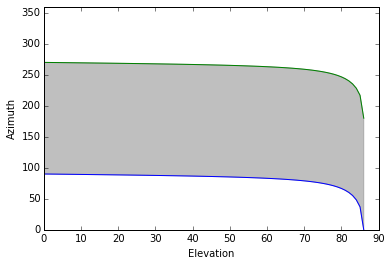

In [44]:
azlimlo=360
azlimup=180
el=np.linspace(0,90-eloff,90-eloff+1)*np.pi/180
omega=np.arcsin(np.sin(el)/np.cos(eloff*np.pi/180))
azcor=-np.arctan2(np.cos(omega),np.sin(omega)*np.sin(eloff*np.pi/180))*180/np.pi
lowerang=azlimlo-azcor-360
upperang=azlimup-azcor
plt.plot(el*180/np.pi,lowerang)
plt.plot(el*180/np.pi,upperang)
plt.fill_between(el*180/np.pi,lowerang, upperang, color='grey', alpha='0.5')
plt.ylim(0,360)
plt.xlabel("Elevation")
plt.ylabel("Azimuth")
filtel=el*180/np.pi==elevation

In [197]:
time.now()

<Time object: scale='utc' format='datetime' value=2016-11-04 14:55:24.135416>

In [206]:
# Observation plan
for i in range(24):
    ecci = EarthLocation(lat=4.71*u.deg, lon=-72.07*u.deg, height=2600*u.m)
    for j in ['00','15','30','45']:
        time = Time('%s %i:%s:00' % (str(time.now())[:10],i,j)) 
        objaltaz = obj.transform_to(AltAz(obstime=time,location=ecci))  
        print time - utcoffset, " Object altitude = {0.alt:.1f}".format(objaltaz)," Object azimuth = {0.az:.1f}".format(objaltaz) 

2016-11-07 19:00:00.000  Object altitude = 15.9 deg  Object azimuth = 238.0 deg
2016-11-07 19:15:00.000  Object altitude = 12.7 deg  Object azimuth = 238.8 deg
2016-11-07 19:30:00.000  Object altitude = 9.5 deg  Object azimuth = 239.5 deg
2016-11-07 19:45:00.000  Object altitude = 6.3 deg  Object azimuth = 240.1 deg
2016-11-07 20:00:00.000  Object altitude = 3.0 deg  Object azimuth = 240.5 deg
2016-11-07 20:15:00.000  Object altitude = -0.3 deg  Object azimuth = 240.9 deg
2016-11-07 20:30:00.000  Object altitude = -3.5 deg  Object azimuth = 241.2 deg
2016-11-07 20:45:00.000  Object altitude = -6.8 deg  Object azimuth = 241.3 deg
2016-11-07 21:00:00.000  Object altitude = -10.1 deg  Object azimuth = 241.3 deg
2016-11-07 21:15:00.000  Object altitude = -13.4 deg  Object azimuth = 241.3 deg
2016-11-07 21:30:00.000  Object altitude = -16.7 deg  Object azimuth = 241.1 deg
2016-11-07 21:45:00.000  Object altitude = -20.0 deg  Object azimuth = 240.8 deg
2016-11-07 22:00:00.000  Object altitud